In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
sns.set()

## Task 2 - SNR

In [3]:
PATH_PLAINTEXT = './textin_attack.npy'
PATH_TRACES = './traces_attack_int16.npy'
PATH_CIPHERTEXT = './textout_attack.npy'

plaintxt_data = np.load(PATH_PLAINTEXT)
trace_data = np.load(PATH_TRACES)
cipher_data = np.load(PATH_CIPHERTEXT)

In [4]:
#trace[plaintext == 0x00]
firstbyte_index = np.where(plaintxt_data[:, 0] == 0)
filter_traces = trace_data[firstbyte_index]
vertical_means = np.nanmean(filter_traces,axis=0)

In [5]:
firstbyte_index = np.where(plaintxt_data[:, 0] == 0)
filter_traces = trace_data[firstbyte_index]
vertical_vars = np.nanvar(filter_traces,axis=0)

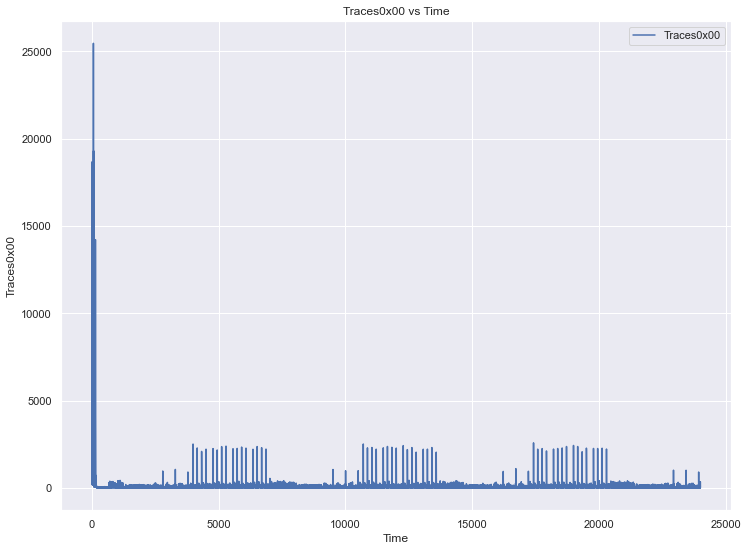

In [6]:
plt.subplots(figsize=(12, 9))
plt.title("Traces0x00 vs Time")
ax = sns.lineplot(x = list(range(24000)), y = vertical_vars, label='Traces0x00')
ax.set(xlabel='Time', ylabel='Traces0x00')
ax.legend()
plt.show()

### a. Create SNR for plaintext input

In [7]:
mean_traces_array = np.zeros([256,24000],dtype=float)
for byte in range(256):
    firstbyte_index = np.where(plaintxt_data[:, 0] == byte)
    filter_traces = trace_data[firstbyte_index]
    vertical_means = np.nanmean(filter_traces,axis=0)
    mean_traces_array[byte] = vertical_means
signal = np.nanvar(mean_traces_array,axis=0)

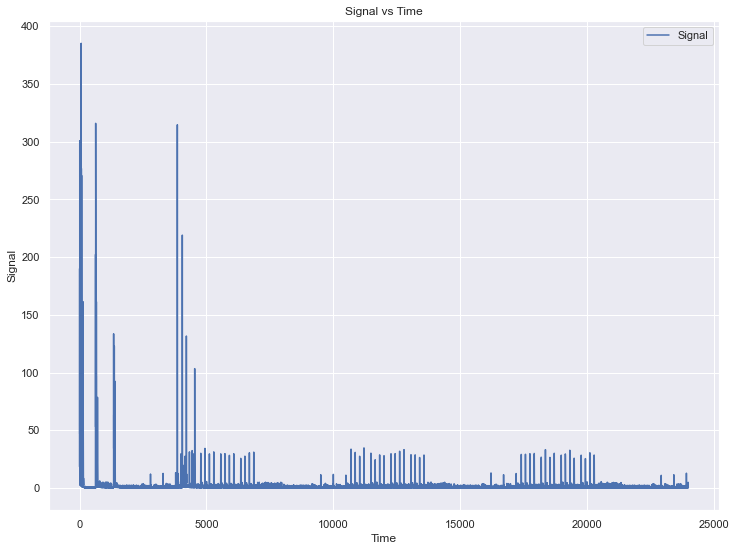

In [8]:
plt.subplots(figsize=(12, 9))
plt.title("Signal vs Time")
ax = sns.lineplot(x = list(range(24000)), y = signal, label='Signal')
ax.set(xlabel='Time', ylabel='Signal')
ax.legend()
plt.show()

In [9]:
var_traces_array = np.zeros([256,24000],dtype=float)
for byte in range(256):
    firstbyte_index = np.where(plaintxt_data[:, 0] == byte)
    filter_traces = trace_data[firstbyte_index]
    vertical_vars = np.nanvar(filter_traces,axis=0)
    var_traces_array[byte] = vertical_vars
noise = np.nanmean(var_traces_array,axis=0)

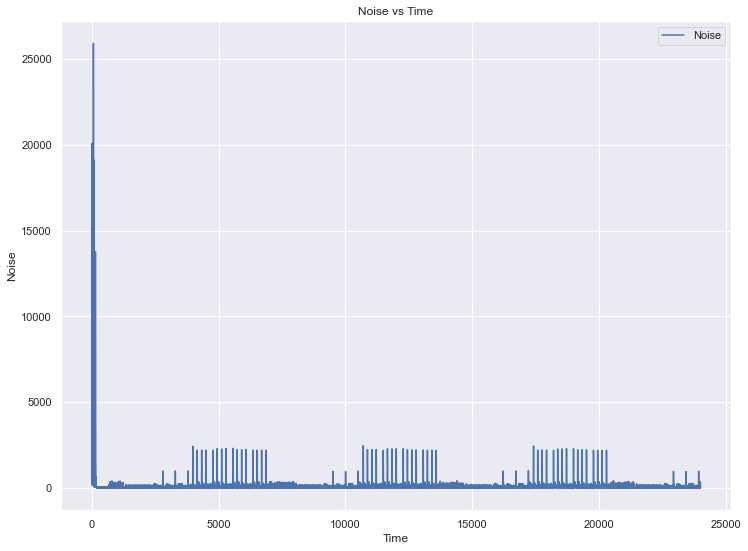

In [10]:
plt.subplots(figsize=(12, 9))
plt.title("Noise vs Time")
ax = sns.lineplot(x = list(range(24000)), y = noise, label='Noise')
ax.set(xlabel='Time', ylabel='Noise')
ax.legend()
plt.show()

In [11]:
snr = np.divide(signal,noise)

<ipython-input-11-491b865be66f>:1: RuntimeWarning: invalid value encountered in true_divide
  snr = np.divide(signal,noise)


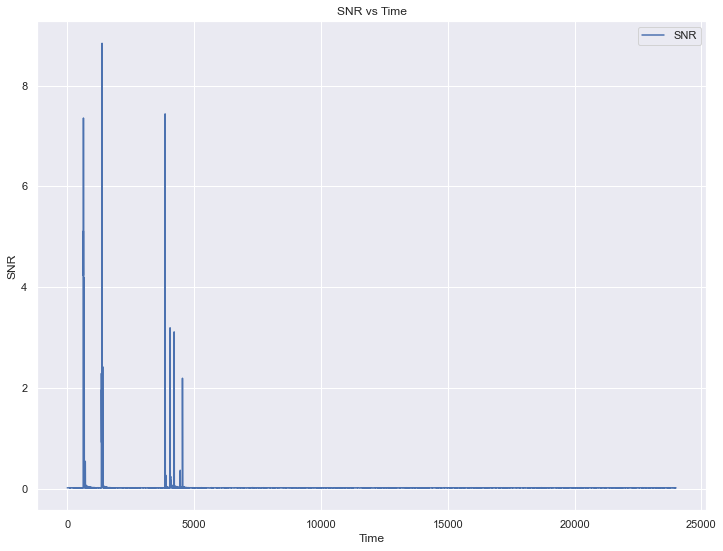

In [12]:
plt.subplots(figsize=(12, 9))
plt.title("SNR vs Time")
ax = sns.lineplot(x = list(range(24000)), y = snr, label='SNR')
ax.set(xlabel='Time', ylabel='SNR')
ax.legend()
plt.show()

In [80]:
np.where(snr > 6)

(array([ 637,  638,  639,  640, 1372, 3857, 3858, 3859], dtype=int64),)

Let's narrow down the range so we can take a closer look at the interesting part:

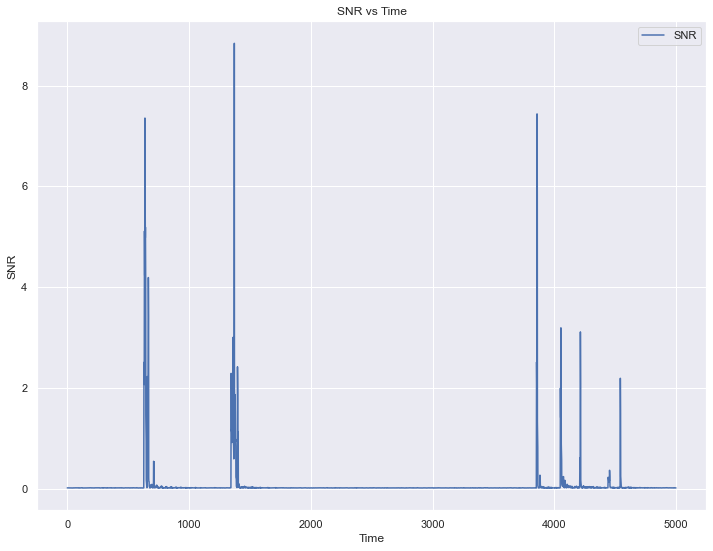

In [13]:
plt.subplots(figsize=(12, 9))
plt.title("SNR vs Time")
ax = sns.lineplot(x = list(range(5000)), y = snr[:5000], label='SNR')
ax.set(xlabel='Time', ylabel='SNR')
ax.legend()
plt.show()

### b. Histogram

select all traces where HW(plaintext) == 0

select of these traces the point in time as identified by the SNR

for this point you create the histogram

#################################

select all traces where HW(plaintext) == 1

select of these traces the point in time as identified by the SNR

for this point you create the histogram

#################################

and so on

In [14]:
sbox = np.array([
        0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
        0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
        0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
        0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
        0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
        0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
        0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
        0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
        0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
        0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
        0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
        0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
        0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
        0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
        0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
        0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

def countSetBits(n):
    count = 0
    while (n):
        count += n & 1
        n >>= 1
    return count

hamming_weight_sbox = np.array(list(map(countSetBits, sbox)))


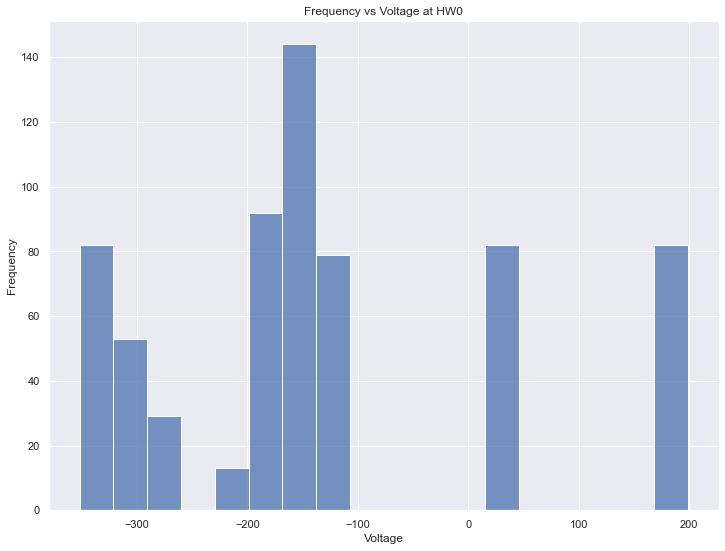

In [15]:
#get all traces where HW(plaintext_firstbit) == 0
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==0)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW0")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

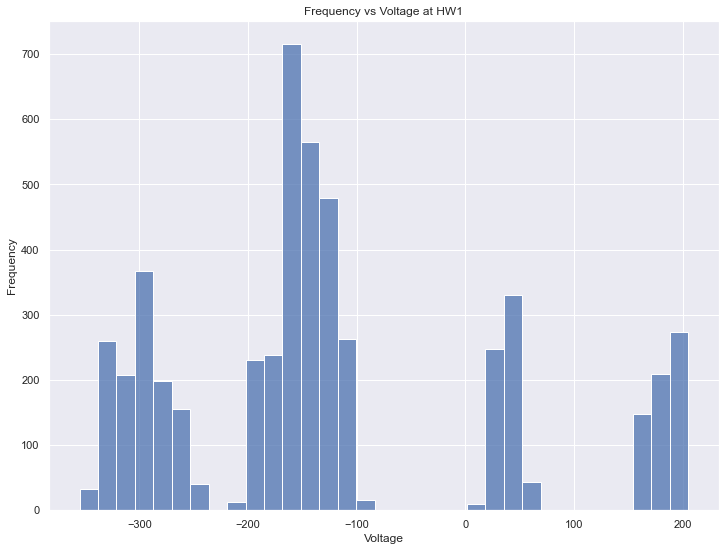

In [16]:
#get all traces where HW(plaintext_firstbit) == 1
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==1)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW1")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

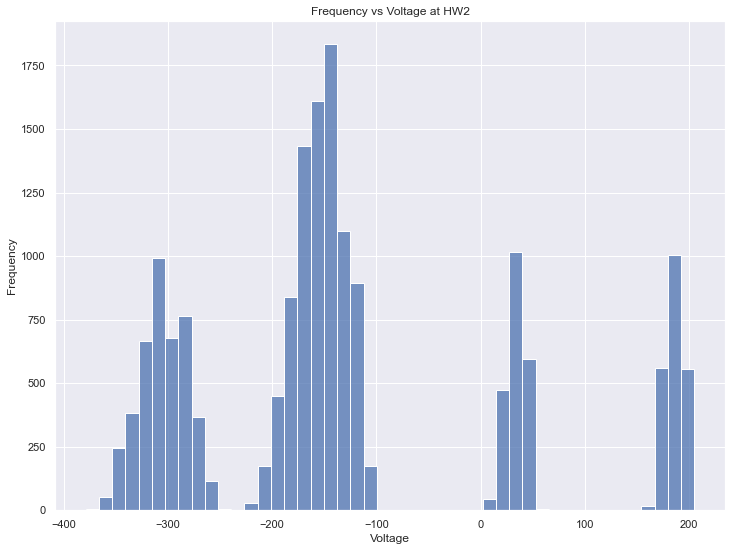

In [17]:
#get all traces where HW(plaintext_firstbit) == 2
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==2)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW2")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

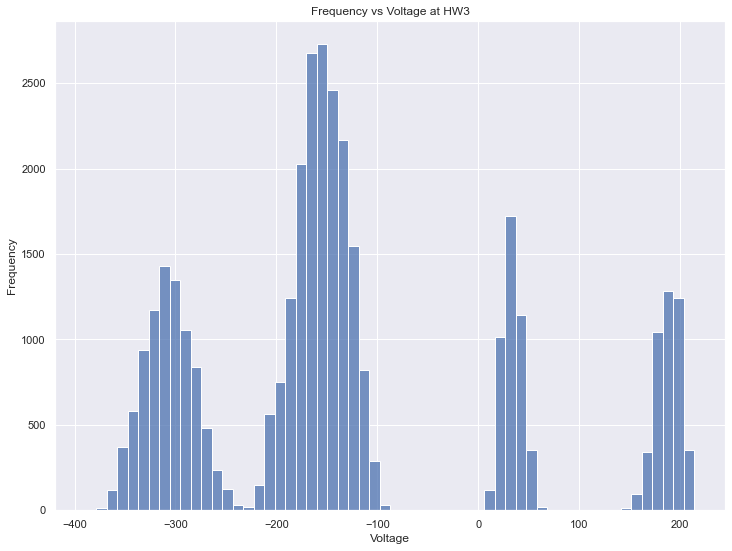

In [18]:
#get all traces where HW(plaintext_firstbit) == 3
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==3)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW3")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

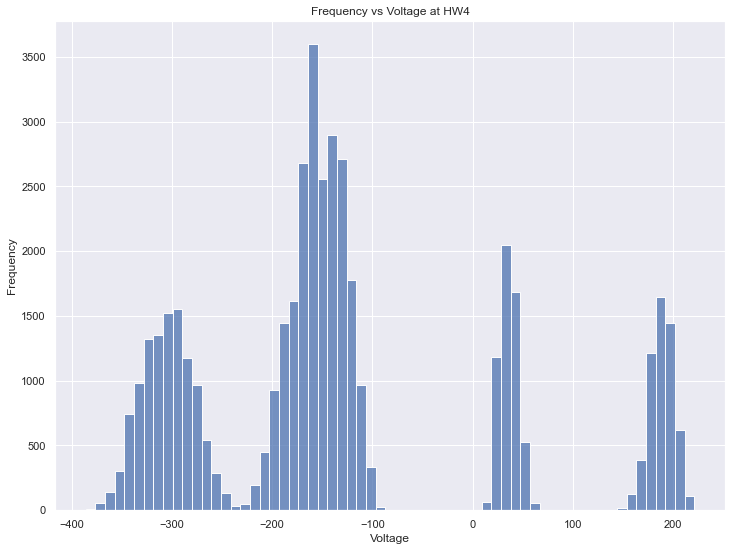

In [19]:
#get all traces where HW(plaintext_firstbit) == 4
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==4)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW4")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

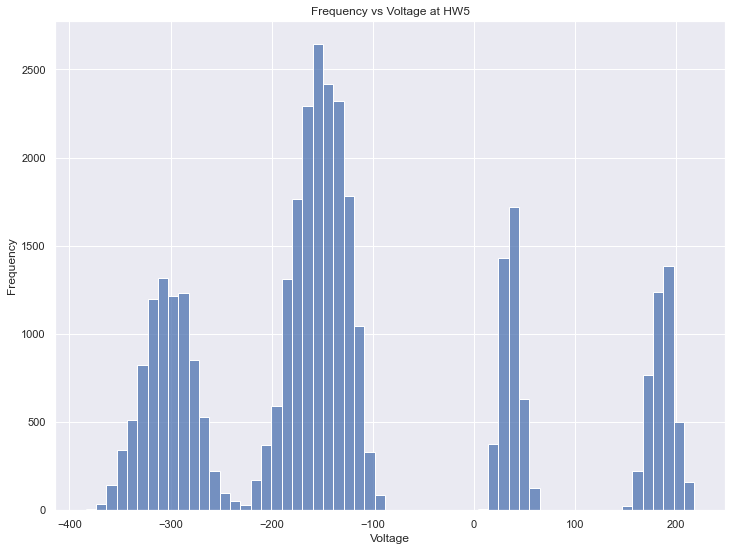

In [20]:
#get all traces where HW(plaintext_firstbit) == 5
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==5)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW5")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

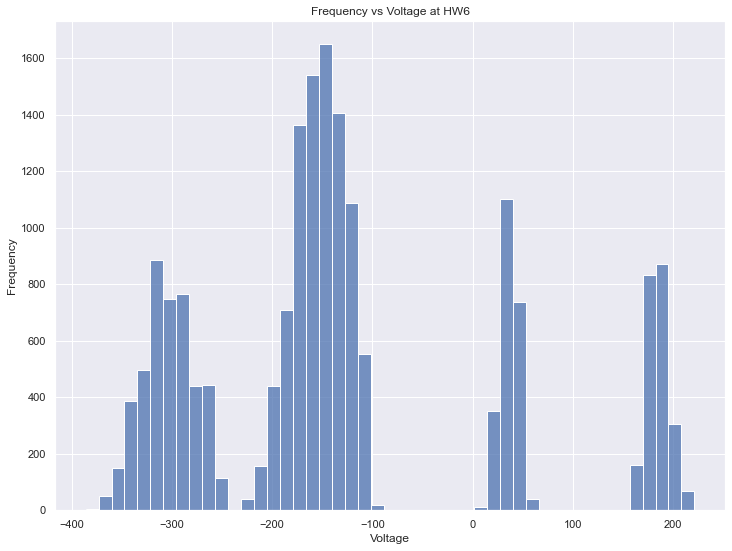

In [21]:
#get all traces where HW(plaintext_firstbit) == 6
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==6)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW6")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

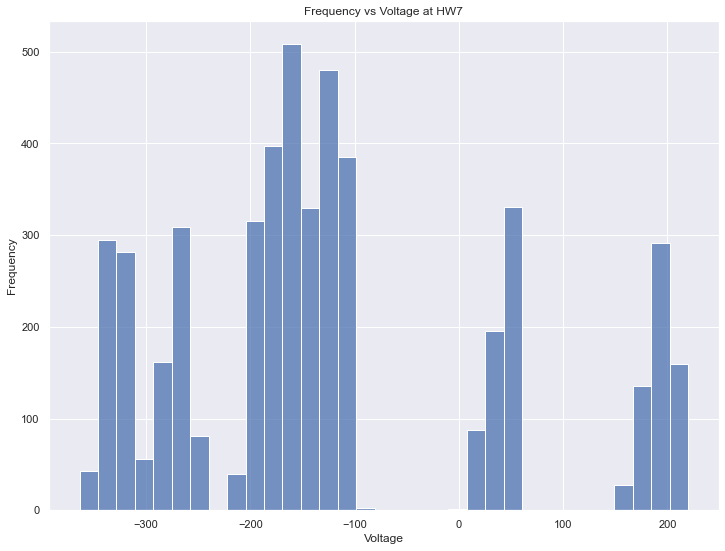

In [22]:
#get all traces where HW(plaintext_firstbit) == 7
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==7)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW7")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

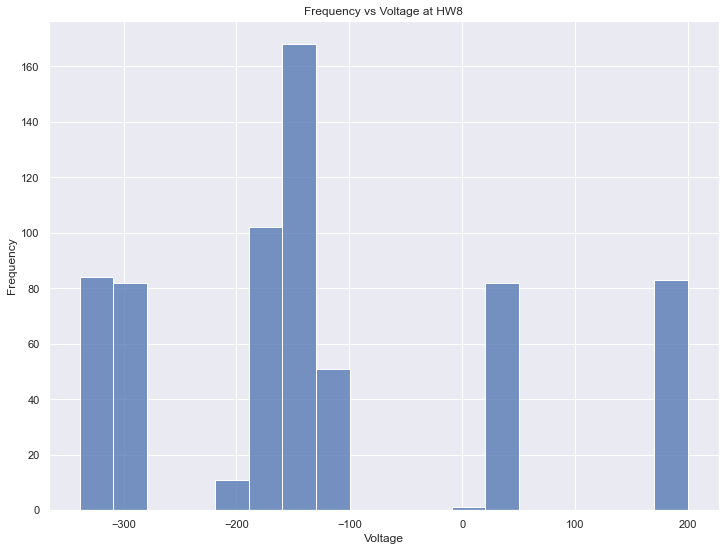

In [23]:
#get all traces where HW(plaintext_firstbit) == 8
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==8)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW8")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

### c. Average traces with same input data

In [26]:
## get traces where firstbyte input = 0x00:
firstbyte_index = np.where(plaintxt_data[:, 0] == byte)
filter_traces = trace_data[firstbyte_index]
vertical_means = np.nanmean(filter_traces,axis=0)

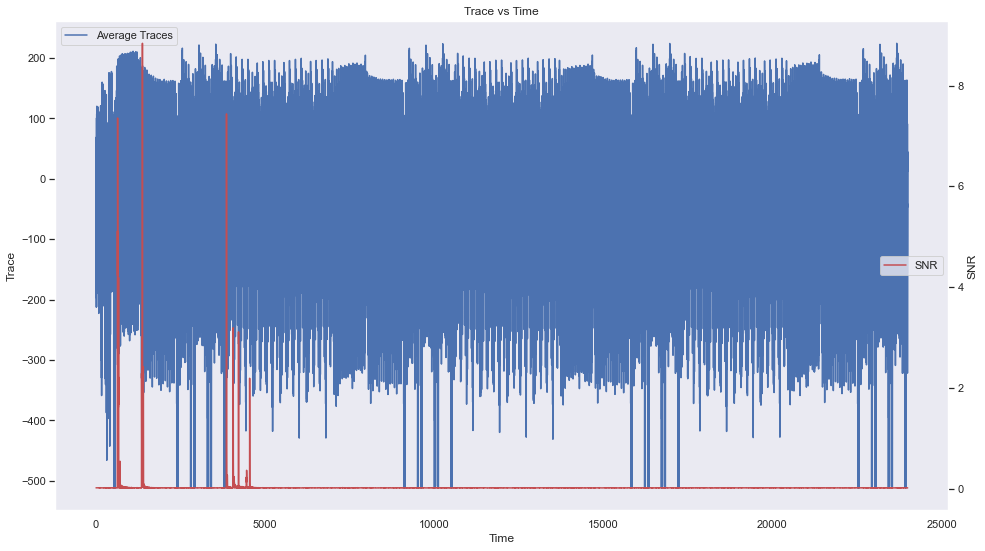

In [39]:
plt.subplots(figsize=(16, 9))
plt.title("Trace vs Time")
ax = sns.lineplot(x = list(range(24000)), y = vertical_means, label='Average Traces')
ax.grid(False)
ax.set(xlabel='Time', ylabel='Trace')
ax2 = plt.twinx()
sns.lineplot(x = list(range(24000)), y = snr, label='SNR', color="r", ax=ax2)
ax2.set(xlabel='Time', ylabel='SNR')
ax2.grid(False)
ax2.legend(loc=5)
ax.legend()
plt.show()

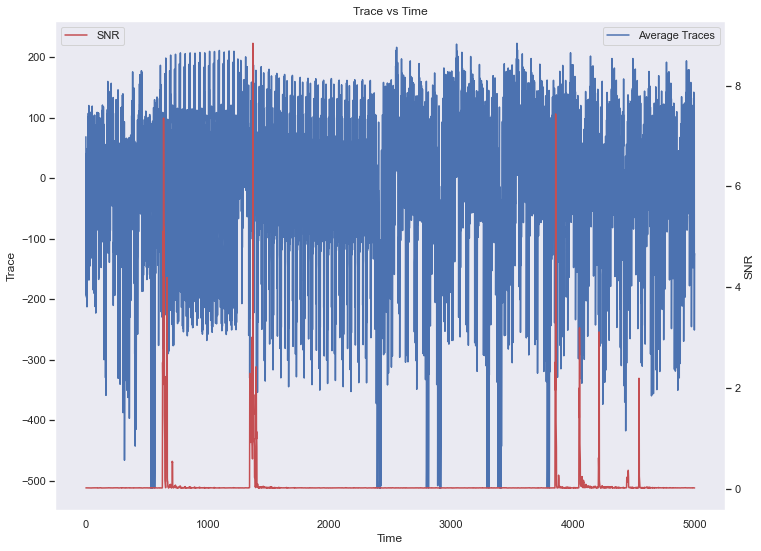

In [38]:
plt.subplots(figsize=(12, 9))
plt.title("Trace vs Time")
ax = sns.lineplot(x = list(range(5000)), y = vertical_means[:5000], label='Average Traces')
ax.grid(False)
ax.set(xlabel='Time', ylabel='Trace')
ax2 = plt.twinx()
sns.lineplot(x = list(range(5000)), y = snr[:5000], label='SNR', color="r", ax=ax2)
ax2.set(xlabel='Time', ylabel='SNR')
ax2.grid(False)
ax2.legend(loc=2)
ax.legend()
plt.show()

### d. CPA attack

In [122]:
#subset traces range for attacking:
subtrace_data = trace_data[:,500:2000]

#intermediate values at byte 0:
sbox_Hypothetical = np.zeros([256, 20000])
for i in range(256):
    sbox_Hypothetical[i] = hamming_weight_sbox[np.bitwise_xor(plaintxt_data[:,0],i)]
sbox_Hypothetical = sbox_Hypothetical.T

In [123]:
r = np.zeros([256, subtrace_data.shape[1]])
for t in tqdm(range(subtrace_data.shape[1])):
    traceMean = np.mean(subtrace_data[:, t])
    for k in range(256):
        powerMean = np.mean(sbox_Hypothetical[:, k])
        difPower = sbox_Hypothetical[:, k] - powerMean
        difTrace = subtrace_data[:, t] - traceMean
        nominator = np.sum(np.multiply(difPower, difTrace))
        denominator = np.sqrt(np.sum(np.multiply(difPower, difPower))*np.sum(np.multiply(difTrace,difTrace)))
        r[k][t] = nominator / denominator

  0%|          | 0/1500 [00:00<?, ?it/s]

<ipython-input-123-4e8dc4a388dc>:10: RuntimeWarning: invalid value encountered in double_scalars
  r[k][t] = nominator / denominator


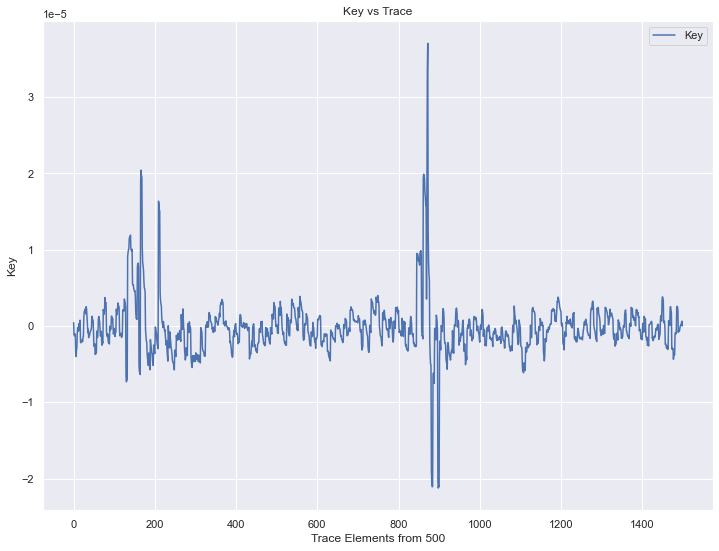

In [124]:
plt.subplots(figsize=(12, 9))
plt.title("Key vs Trace")
ax = sns.lineplot(x = list(range(subtrace_data.shape[1])), y = np.mean(r,axis=0), label='Key')
ax.set(xlabel='Trace Elements from 500', ylabel='Key')
ax.legend()
plt.show()

In [125]:
np.nanargmax(r[:,np.nanargmax(np.mean(r,axis=0))])

42